## [Enzo LOUIS]
## [Recherche personnage] Etude des répliques et des mentions entre les personnages
**Objectif : montrer les moments que le scénariste a choisi pour faire évoluer l'histoire de chaque personnage**

*Interprétation des résultats obtenus mis en perspective avec l'analyse d'émotion afin de repérer les vrais pic de popularité du personnage*

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import re

df = pd.read_csv("../Analyse_Sentiments/friends_dialogues_final.csv", encoding='utf-8')

PATH = "../../src/main/resources/les_png/recherche_personnage/"

def clean_line(line):
    """
    Enlève les annotations/didascalies, les ensemble de mots entre parenthèses
    Mets en minuscule
    Enlève les caractères spéciaux
    Split la ligne en mots
    :param line: réplique de dialogue
    :return: liste de mots
    """
    line = re.sub(r'\([^)]*\)', '', line)
    # lower + clean special char + split
    return re.sub(r'[^\w\s]', '', line.lower()).split()

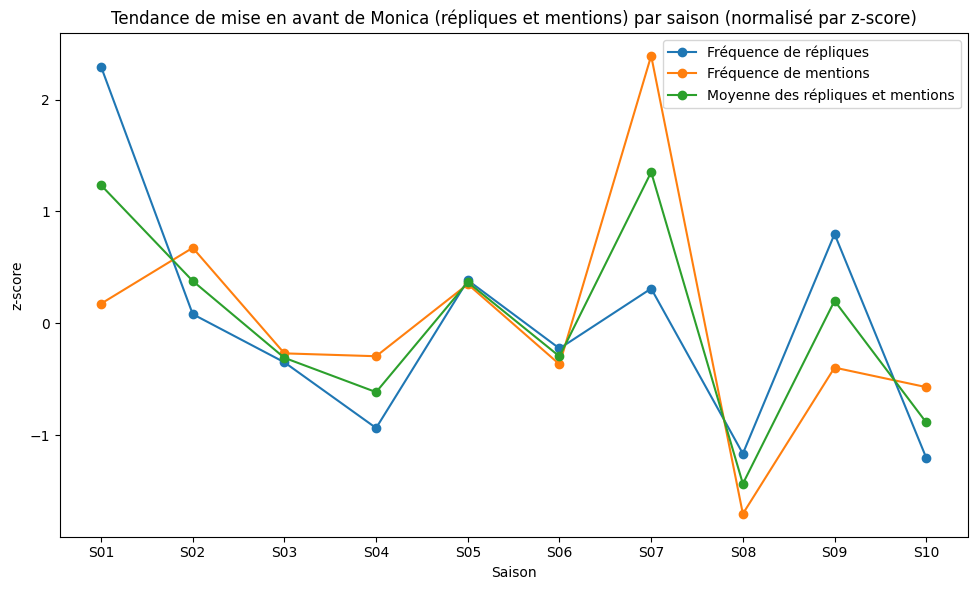

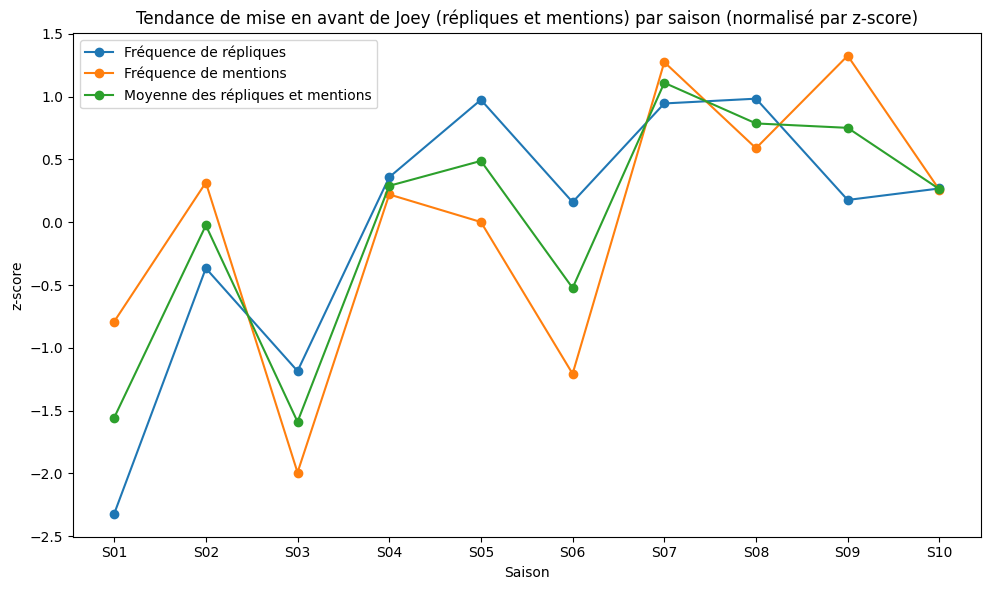

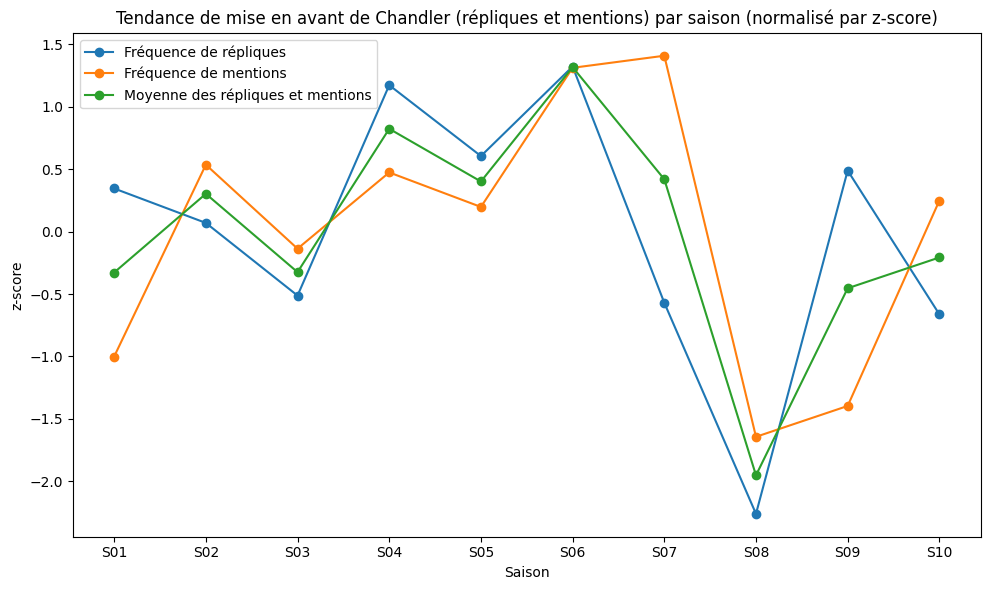

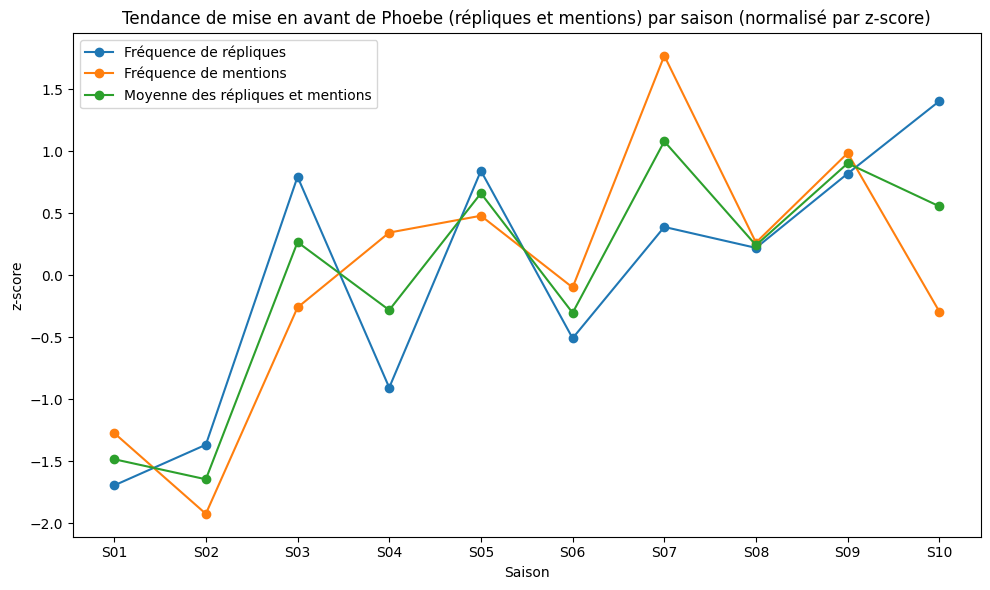

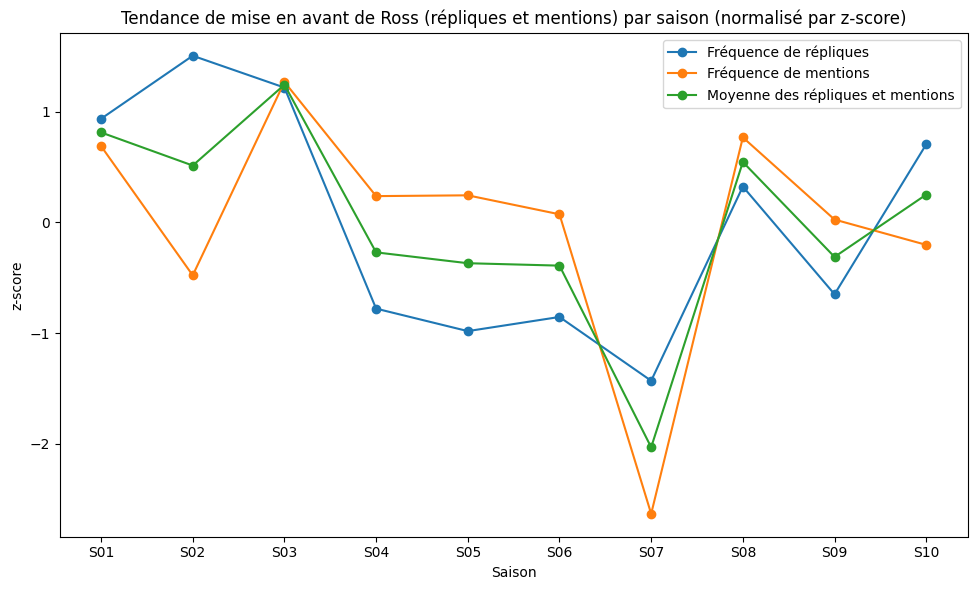

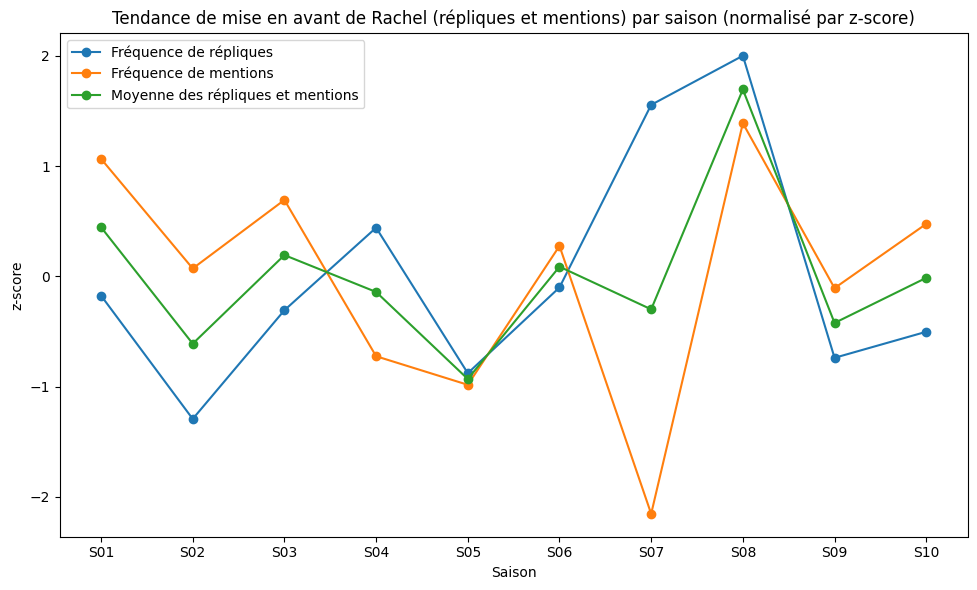

In [11]:
def recherche_pic_de_popularite_personnage():
    saisons = sorted(df['season'].unique())
    characters = ['monica', 'joey', 'chandler', 'phoebe', 'ross', 'rachel']

    mentions_per_season = pd.DataFrame(0, index=saisons, columns=characters)

    # parcours de toutes les lignes pour compter les mentions par saison
    for _, row in df.iterrows():
        saison = row['season']
        # Nettoyage de la ligne (éviter didascalies et autres annotations)
        ligne = clean_line(row['line'])
        speaker = row['character'].lower()

        # pour chaque mot dans la ligne, si c'est un personnage, on incrémente le compteur pour cette saison
        for mot in ligne:
            # on vérifie si le mot est un personnage et n'est pas le locuteur de la ligne
            if mot in characters and mot != speaker:
                # mot est donc un personnage ici
                mentions_per_season.at[saison, mot] += 1
    
    # total des mentions par saison afin de normaliser
    total_lines_per_season = mentions_per_season.sum(axis=1)

    # normalisation par le total des mentions dans la saison
    mentions_per_season_norm = mentions_per_season.div(total_lines_per_season, axis=0)

    # total des répliques par saison afin de normaliser
    total_lines_per_season = df.groupby('season').size()
    
    # nombre de répliques par personnage et saison
    count = df.groupby(['character', 'season']).size().reset_index(name='line_count')

    # ajout du total des répliques dans la saison correspondante
    count['total_lines_in_season'] = count['season'].map(total_lines_per_season)

    # normalisation par le total des répliques de la saison
    count['line_count_norm'] = count['line_count'] / count['total_lines_in_season']

    pivot_norm = count.pivot(index='character', columns='season', values='line_count_norm').fillna(0)
    mentions_per_season_norm = mentions_per_season_norm.T

    # Z-scores pour les mentions
    mentions_zscore = pd.DataFrame(
        zscore(mentions_per_season_norm, axis=1, nan_policy='omit'),
        index=mentions_per_season_norm.index,
        columns=mentions_per_season_norm.columns
    )

    # Z-scores pour les répliques
    line_zscore = pd.DataFrame(
        zscore(pivot_norm, axis=1, nan_policy='omit'),
        index=pivot_norm.index,
        columns=pivot_norm.columns
    )

    # 6 graphiques pour chaque personnage
    for character in characters:
        # affichage
        plt.figure(figsize=(10, 6))
        plt.title(f"Tendance de mise en avant de {character.capitalize()} (répliques et mentions) par saison (normalisé par z-score)")
        plt.xlabel("Saison")
        plt.ylabel("z-score")
        plt.tight_layout()
        plt.plot(line_zscore.T[character.capitalize()], marker='o', label='Fréquence de répliques')
        plt.plot(mentions_zscore.T[character], marker='o', label='Fréquence de mentions')
        plt.plot((line_zscore.T[character.capitalize()]+mentions_zscore.T[character])/2, marker='o', label='Moyenne des répliques et mentions')
        plt.legend()
        plt.savefig(f"{PATH}/graphe_tendance_mise_en_avant_{character}_par_scenariste.png", dpi=300)
        plt.show()

recherche_pic_de_popularite_personnage()

### Pré-analyse fréquence de répliques pour chaque persos

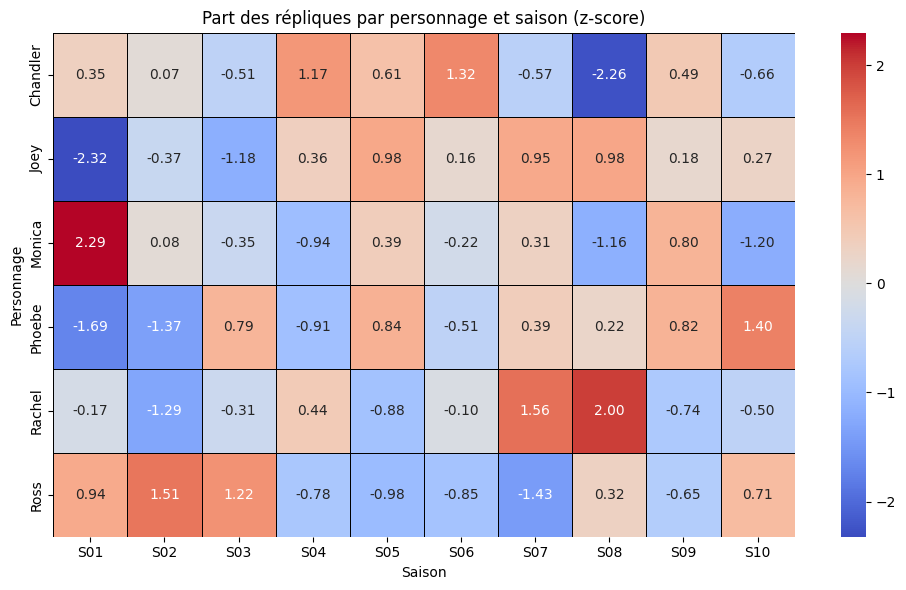

In [ ]:
import seaborn as sns

def count_lines_by_character_and_season(axe):
    df['season'] = df['season'].apply(lambda x: x)
    
    total_lines_per_season = df.groupby('season').size()

    count = df.groupby(['character', 'season']).size().reset_index(name='line_count')

    count['total_lines_in_season'] = count['season'].map(total_lines_per_season)

    count['line_count_norm'] = count['line_count'] / count['total_lines_in_season']

    pivot_norm = count.pivot(index='character', columns='season', values='line_count_norm').fillna(0)

    # Z-score par personnage (comparaison intra-personnage)
    pivot_z = pd.DataFrame(
        zscore(pivot_norm, axis=axe, nan_policy='omit'),
        index=pivot_norm.index,
        columns=pivot_norm.columns
    ).fillna(0)

    # Affichage
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_z, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, linecolor='black')
    plt.title("Part des répliques par personnage et saison (z-score)")
    plt.xlabel("Saison")
    plt.ylabel("Personnage")
    plt.tight_layout()
    # plt.savefig("mise_en_avant_personnage_par_replique/frequence_replique_normalise_par_saison.png", dpi=300)
    plt.show()

count_lines_by_character_and_season(axe=1)